# Lineages
Natalia Vélez, July 2020

The goal of this notebook is to construct family graphs (directed graph from parent —> child) out of the lifelog data. These family trees will be used in several other analyses.

In [1]:
%matplotlib inline

import os, re, glob, json
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

from os.path import join as opj
from tqdm import notebook
from ast import literal_eval as make_tuple

sns.set_context('talk')
sns.set_style('white')

# Helper function
def gsearch(*args): return glob.glob(opj(*args)) # Search for fukes
def clean_tuple(s):
    try:
        t = make_tuple(s)
    except ValueError:
        t = ()
    return t

Get data from all eras:

In [2]:
era_files = glob.glob('outputs/lifelogs*_data.tsv')
era_list = []

for f in era_files:
    era_data = pd.read_csv(f, sep='\t', index_col=0)
    era_list.append(era_data)
    
era_df = pd.concat(era_list)
era_df = era_df.drop(columns=['server', 'release', 'era'])
era_df.head()

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,event,timestamp,avatar,player,age,sex,location,parent,cause_of_death,killer
0,B,1573257612,2251779,9b90770e9c4144721a6abe58faa161ef6b555786,NaN,F,"(-334, -521)",2251499,NaN,NaN
1,D,1573257621,2251778,c17d2f3663837c82e4f7669a40aa6f618e89e57a,0.54,F,"(-361, -410)",NaN,hunger,NaN
2,B,1573257622,2251780,afb7da00e454ba6dac3cddbccfb8c14c5680ab1b,NaN,F,"(-184, -916)",2251439,NaN,NaN
3,B,1573257623,2251781,abbebf5a1056fd091dff74135c014aa1081435d8,NaN,F,"(-416, -524)",2251557,NaN,NaN
4,D,1573257624,2251740,bd6841eb13118ce2a0453e5802b91f7ec0c1e20e,3.72,F,"(-238, -855)",NaN,hunger,NaN


Find players' parents and time/location of birth:

In [3]:
idx_vars = ['player', 'avatar']
births = era_df[era_df['event'] == 'B'].copy()
births = births[idx_vars + ['timestamp', 'parent', 'location']]
births = births.rename({'location': 'birth', 'timestamp': 'tBirth'}, axis='columns')
births.head()

,player,avatar,tBirth,parent,birth
0,9b90770e9c4144721a6abe58faa161ef6b555786,2251779,1573257612,2251499,"(-334, -521)"
2,afb7da00e454ba6dac3cddbccfb8c14c5680ab1b,2251780,1573257622,2251439,"(-184, -916)"
3,abbebf5a1056fd091dff74135c014aa1081435d8,2251781,1573257623,2251557,"(-416, -524)"
7,bd6841eb13118ce2a0453e5802b91f7ec0c1e20e,2251782,1573257629,2251463,"(-156, -855)"
9,40a960756347fa0a7c3d14791bd0379c6cc754cf,2251783,1573257634,2251595,"(-155, -962)"


Find time and circumstances of death:

In [4]:
deaths =  era_df[era_df['event'] == 'D'].copy()
deaths = deaths[idx_vars + ['timestamp', 'location', 'age', 'cause_of_death']]
deaths = deaths.rename({'location': 'death', 'timestamp': 'tDeath'}, axis='columns')

deaths.head()

,player,avatar,tDeath,death,age,cause_of_death
1,c17d2f3663837c82e4f7669a40aa6f618e89e57a,2251778,1573257621,"(-361, -410)",0.54,hunger
4,bd6841eb13118ce2a0453e5802b91f7ec0c1e20e,2251740,1573257624,"(-238, -855)",3.72,hunger
5,7e058600565826811059c93c9ce403d7b6c4533b,2251577,1573257625,"(-201, -903)",21.72,hunger
6,40a960756347fa0a7c3d14791bd0379c6cc754cf,2251776,1573257626,"(-765, -581)",0.69,hunger
8,ac7e03fde959b54812abf9798cc25cf55b3d6baa,2251722,1573257632,"(-323, -508)",5.90,hunger


## Merge births and deaths

**DEBUG:** Unique avatar IDs in births and deaths

In [5]:
# Get unique avatars in each DF
unique_births = np.unique(births['avatar'])
unique_deaths = np.unique(deaths['avatar'])

# How many total unique avatars?
unique_avatars = np.concatenate((unique_births, unique_deaths))
unique_avatars = np.unique(unique_avatars)

# Which avatars are in deaths but not births, and vice versa?
not_in_deaths = np.setdiff1d(unique_births, unique_deaths)
not_in_births = np.setdiff1d(unique_deaths, unique_births)

print('%i unique avatars' % len(unique_avatars))
print('%i in both' % len(np.intersect1d(unique_births, unique_deaths)))
print('%i not in deaths: %s...' % (len(not_in_deaths), not_in_deaths[:5],))
print('%i not in births: %s...' % (len(not_in_births), not_in_births[:5],))

3159745 unique avatars
3153464 in both
6281 not in deaths: [ 221 2850 2851 2852 2937]...
0 not in births: []...


Merge & clean up:

In [6]:
print('Births: %s' % (births.shape,))
print('Deaths: %s' % (deaths.shape,))

life_df = pd.merge(births, deaths, on=idx_vars, how='outer')
print('Merged dataframe: %s' % (life_df.shape,))

# Turn birth/death locations to tuples
print('Birth/death locations...')
life_df['birth'] = life_df['birth'].apply(clean_tuple).apply(np.array)
life_df['death'] = life_df['death'].apply(clean_tuple).apply(np.array)

# Split coordinates
print('Splitting into x/y coords...')
life_df[['birthX', 'birthY']] = pd.DataFrame(life_df['birth'].tolist(),
                                              index=life_df.index)   
life_df[['deathX', 'deathY']] = pd.DataFrame(life_df['death'].tolist(),
                                              index=life_df.index)

# Parse player IDs
print('Parsing player IDs...')
life_df['avatar'] = life_df['avatar'].astype(np.int)

# Parse parent IDs
print('Parsing parents...')
#life_df['parent'] = life_df['parent'].str.extract('(noParent|(?<=parent=)[0-9]+)')
life_df['parent'] = life_df['parent'].str.replace('noParent', '-1')
life_df['parent'] = life_df['parent'].astype(np.int)

# Order from most recent
print('Cleaning up...')
life_df = life_df.sort_values('tBirth', ascending=False)
life_df = life_df.reset_index(drop=True)

Births: (3159745, 5)
Deaths: (3153464, 6)
Merged dataframe: (3159745, 9)
Birth/death locations...
Splitting into x/y coords...
Parsing player IDs...
Parsing parents...
Cleaning up...


In [7]:
print(life_df.shape)
life_df.tail()

(3159745, 13)


,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY
3159740,ae87cea72e02d701fbb807b56113e3f7a3d20b83,6,1548814231,5,"[1366, -395]",1.548815e+09,"[1438, -435]",6.46,hunger,1366,-395,1438.0,-435.0
3159741,77a67da50b453a570d1e3311a56cd9da89187cd2,5,1548814227,-1,"[1366, -395]",1.548816e+09,"[1388, -435]",39.76,murdered,1366,-395,1388.0,-435.0
3159742,0c1781b6944db9e58b5d71adfe64af09fedad796,4,1548814226,3,"[1453, -436]",1.548816e+09,"[1390, -436]",26.40,murdered,1453,-436,1390.0,-436.0
3159743,ba474919bfbe67b14ec6e6fd05c19f383152b1b2,3,1548814222,-1,"[1453, -436]",1.548815e+09,"[1442, -419]",21.21,hunger,1453,-436,1442.0,-419.0
3159744,a51edcb77a3900d53adc61d394876c5ca7417486,2,1548804597,-1,"[50, -7]",1.548807e+09,"[64, -8]",57.49,hunger,50,-7,64.0,-8.0


## Parse names

Helper function: Remove from data...

* Roman numerals (including some nonsense ones at high-gen numbers)
* Kin labels? (e.g., SHINA1580640)

In [8]:
def is_roman(s):
    # Checks if string is a "valid" Roman numeral
    # Note this includes some *cough*idiosyncratic*cough* numerals in the OHOL dataset:
    # e.g., CLXLIII => True (but actually nonsense)
    roman_regex  = 'M{0,4}(CM|CD|D?C{0,3})(LXL|XC|XL|L?X{0,3})(IX|IV|V?I{0,3})'
    roman_match = re.match(roman_regex, s)
    
    str_length = len(s)
    match_length = roman_match.span()[1]
    
    return str_length == match_length

def is_kin(s, idx):
    kin_regex = '[A-Z]{0,}[0-9]+'
    kin_match = re.search(kin_regex, s)
    return bool(kin_match) & (idx > 0)

def is_valid(s, idx):
    
    not_roman = not is_roman(s)
    not_kin = not is_kin(s, idx)
    
    return not_roman & not_kin

Find name files:

In [9]:
data_dir = '../../data'
name_files = glob.glob(opj(data_dir, 'publicLifeLogData', 'lifeLog_bigserver2*', '*names.txt'))
name_files.sort()
print(*[os.path.basename(f) for f in name_files[:5]], sep='\n')

2019_01January_29_Tuesday_names.txt
2019_01January_30_Wednesday_names.txt
2019_01January_31_Thursday_names.txt
2019_02February_01_Friday_names.txt
2019_02February_02_Saturday_names.txt


Iterate over name files and extract names:

In [10]:
name_list = []
re.compile("^([A-Z][0-9]+)+$")

for f in notebook.tqdm(name_files):
    with open(f, 'r') as handle:
        data_str = handle.read().splitlines()

    data = []
    for s in data_str:
        row_data = s.split() # Split lines
        row_data = [si for idx, si in enumerate(row_data) if is_valid(si, idx)]
        
        if len(row_data) > 3:
            row_data.remove('EVE')
            print('Corrected: %s' % row_data)

        while len(row_data) < 3: 
            row_data.append('')

        name_list.append(row_data)

Corrected: ['386865', 'MOON', 'ROA']
Corrected: ['388702', 'MARTHA', 'LIGHT']
Corrected: ['1240637', 'ALEX', 'CHAN']
Corrected: ['1577563', 'KNIGHT', 'FIERRO']
Corrected: ['1579101', 'LARIAH', 'HANNAM']
Corrected: ['1579766', 'JACKIE', 'WISCOMBE']
Corrected: ['1580507', 'BENJAMIN', 'GIOVANNI']



Assemble into dataframe:

In [11]:
name_df = pd.DataFrame(name_list, columns=['avatar', 'first', 'last'])
name_df['avatar'] = name_df['avatar'].astype(np.int)
name_df.head()

,avatar,first,last
0,5,EVE,ARK
1,4,SLY,
2,6,FOX,ARK
3,9,EVE,ISA
4,10,TESIA,ISA


Merge with `life_df`:

In [12]:
life_df = pd.merge(life_df, name_df, on='avatar')
life_df.head()

,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last
0,06d8ab86b0daf11b13a446b87f770aa20bee1ca0,3308603,1599462917,3308581,"[-63752, -504]",NaN,[],NaN,NaN,-63752,-504,NaN,NaN,SUPERIOR,MATSU
1,67bffa53500e2c626edc407409b6550996b748db,3308602,1599462864,3308575,"[-63753, -507]",NaN,[],NaN,NaN,-63753,-507,NaN,NaN,FEATHER,MATSU
2,fbc0168048713cfaf6ef6a350c0171e7b2b0af4a,3308601,1599462805,3308564,"[-63762, -523]",NaN,[],NaN,NaN,-63762,-523,NaN,NaN,SASHA,MATSU
3,5d5050247e485d0224df4e392118c27b8ee3a88b,3308598,1599462667,3308575,"[-63747, -498]",NaN,[],NaN,NaN,-63747,-498,NaN,NaN,DRAGON,MATSU
4,310d12780dbb316a3b50f83adbf9ce76973172bb,3308597,1599462620,3308571,"[-63756, -508]",1.599464e+09,"[-63841, -520]",28.89,hunger,-63756,-508,-63841.0,-520.0,MODOU,MATSU


Save `life_df` to file:

In [13]:
life_df.to_csv('outputs/all_lifelogs_compact.tsv', sep='\t')

## Sanity check: How many lineages can we expect?

Spot eves:

In [15]:
eves = life_df[life_df['parent'] < 0].reset_index()
eves.to_csv('outputs/lineage_input_eves.csv', index=False)
print(eves['avatar'][:10])

0    3308568
1    3308504
2    3308427
3    3308401
4    3308371
5    3308305
6    3308247
7    3308186
8    3308179
9    3308177
Name: avatar, dtype: int64


How many eves?

In [16]:
n_eves = eves.shape[0]
n_births = len(life_df)
eve_rate = n_eves/n_births
print('%i Eves out of %i births (%0.2f%%)' % (n_eves, n_births, eve_rate*100))

59879 Eves out of 1826661 births (3.28%)


Eve spawn rate over time:

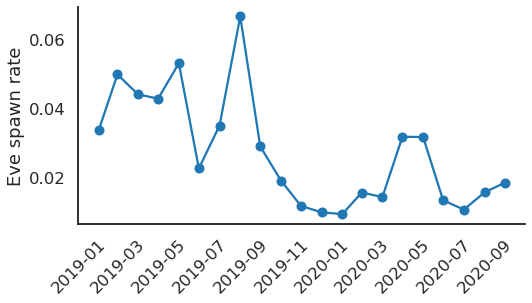

In [17]:
eve_rate = life_df.copy()
eve_rate['is_eve'] = eve_rate['parent'] < 0
eve_rate['date'] = pd.to_datetime(eve_rate['tBirth'],unit='s')
eve_rate['month'] = eve_rate['date'].dt.to_period('M')

eve_rate = eve_rate.groupby('month')['is_eve'].agg(['count', 'sum']).reset_index()
eve_rate = eve_rate.rename(columns={'count': 'n_births', 'sum': 'n_eves'})
eve_rate['eve_rate'] = eve_rate['n_eves']/eve_rate['n_births']

fig,ax=plt.subplots(figsize=(8,4))
ax.plot_date(eve_rate['month'], eve_rate['eve_rate'], '-o')
ax.set(ylabel='Eve spawn rate')
plt.xticks(rotation=45)
sns.despine()

## Parent-child pairs

Helper: Search recursively through lifelogs, starting with Eve

In [19]:
# All parent-child links
parent_df = life_df[['avatar', 'parent']].copy()
parent_df.to_csv('outputs/lineage_input_parents.csv', index=False)
parent_df.head()

,avatar,parent
0,3308603,3308581
1,3308602,3308575
2,3308601,3308564
3,3308598,3308575
4,3308597,3308571


In [ ]:
def search_fam(player):
    descendants = parent_df.loc[parent_df['parent'] == player, 'avatar'].values
    
    for d in descendants:
        descendants = np.append(descendants, search_fam(d))
        
    return descendants

Helper: Write data to JSON file

In [ ]:
def write_json(data, f):
    with open(f, 'w') as outfile:
        json.dump(data, outfile)

All parent-child pairs:

Main loop: Build graphs from parent-child pairs:

In [ ]:
families_list = []

for _, family in notebook.tqdm(eves.iterrows(), total=n_eves):

    eve = family['avatar']
    fam_name = family['last']
    fam_start = family['tBirth']

    fam_nodes = list(search_fam(eve))
    fam_df = parent_df[parent_df['avatar'].isin(fam_nodes)]
    fam = nx.from_pandas_edgelist(fam_df, 'parent', 'avatar', None, nx.DiGraph())    
    fam.add_node(str(eve))

    all_members = fam_nodes + [eve]

    if not len(fam_name):
        fam_name = 'nameless'

    fam_id = 'time-%i_eve-%i_name-%s' % (fam_start, eve, fam_name)

    # Add family to list
    families_list.extend([(relative, fam_id) for relative in all_members])

    # Save family data
    out_file = 'outputs/families/families_%s.json' % fam_id
    fam_data = nx.json_graph.node_link_data(fam)
    write_json(fam_data, out_file)

### Tag lifelogs by family
This will be used for several subsequent analyses (e.g., migration, comparing different success measures)

In [ ]:
families_df = pd.DataFrame(families_list, columns=['avatar', 'family'])
families_df.to_csv('outputs/family_playerID.tsv', sep='\t')